In [37]:
%matplotlib inline

In [38]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pylab

#https://github.com/scikit-image/scikit-image/blob/master/skimage/feature/peak.py
from skimage.feature import peak_local_max
#https://github.com/scikit-image/scikit-image/blob/master/skimage/morphology/watershed.py
from skimage.morphology import watershed
#https://github.com/scipy/scipy/blob/v0.16.1/scipy/ndimage/measurements.py#L46
from scipy import ndimage

pylab.rcParams['figure.figsize'] = (10.0, 8.0)

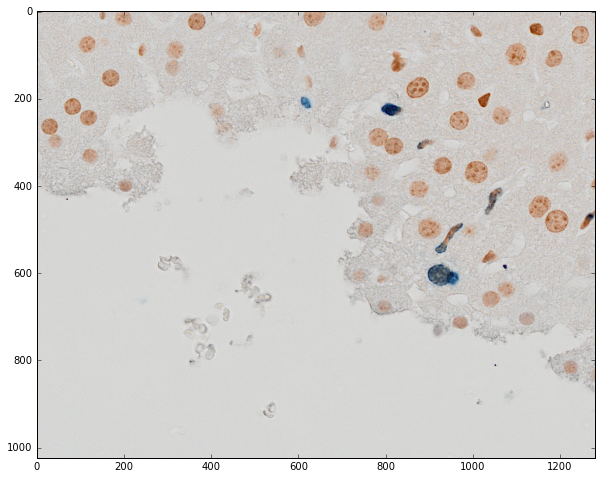

(<matplotlib.image.AxesImage at 0x22208799cf8>, None)

In [39]:
# Import image and create grayscale version in case
img = cv2.imread("Dropbox/BrdUImgs/Image (22).tif")
#img = img[0:200, 700:900]

plt.imshow(img), plt.show()

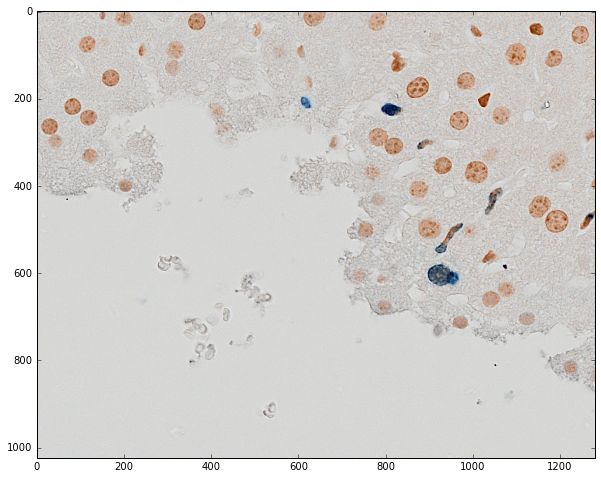

(<matplotlib.image.AxesImage at 0x222087bd710>, None)

In [40]:
#Unsharp Masking
im = cv2.GaussianBlur(img, (0,0), 3)
image = cv2.addWeighted(img, 1.5, im, -0.5, 0)

plt.imshow(image), plt.show()

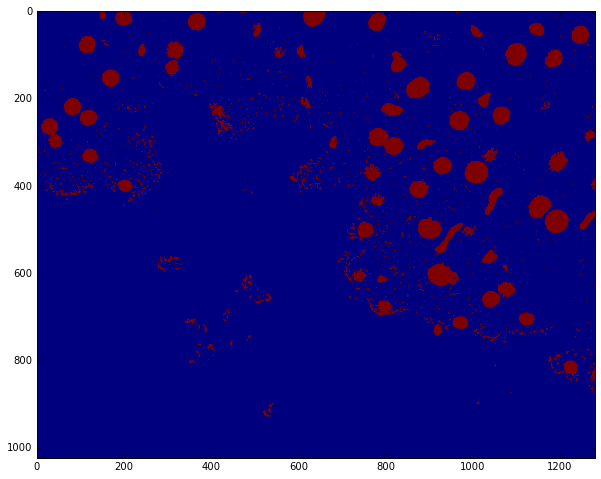

(<matplotlib.image.AxesImage at 0x22208950a58>, None)

In [41]:
#Threshold using inRange
thresh = cv2.inRange(image, (0,0,0),(255,255,175))
#kernel = np.ones((3,3), np.uint8)
#erosion = cv2.erode(thresh, kernel, iterations = 1)
#thresh = cv2.dilate(erosion, kernel, iterations = 1)
plt.imshow(thresh), plt.show()

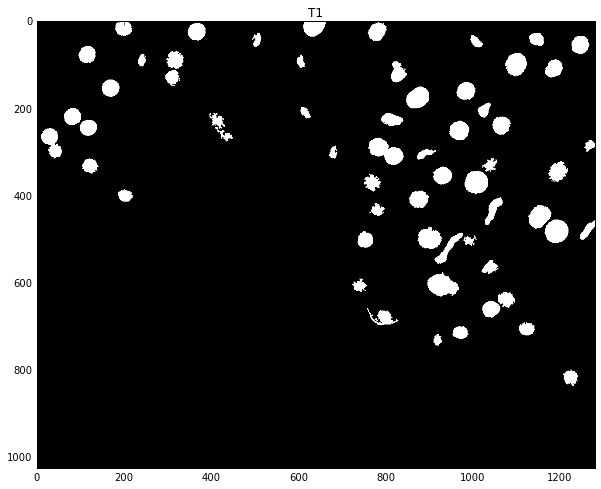

(<matplotlib.image.AxesImage at 0x2220a7ad080>,
 None)

In [42]:
#Fill in contours and dismiss small background objects
im2, contour,h = cv2.findContours(thresh,cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
t1 = np.zeros(thresh.shape, np.uint8)
for cnt in contour:
    area = cv2.contourArea(cnt)
    perimeter = cv2.arcLength(cnt, True)
    if area >= 300: #650:
        cv2.drawContours(t1,[cnt],0,255,-1) 

plt.imshow(t1, cmap = 'gray'), plt.title("T1"), plt.show()

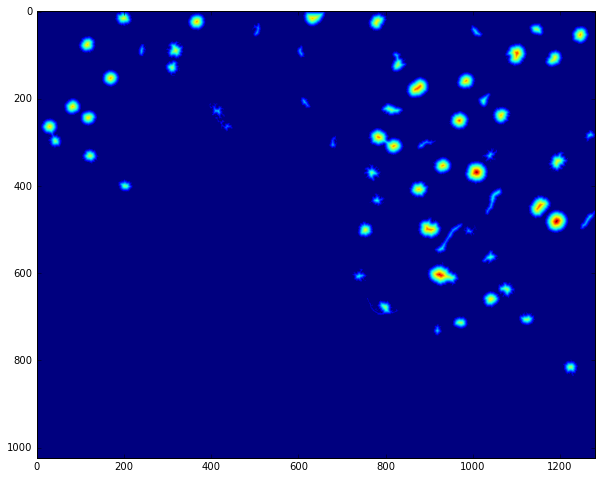

(<matplotlib.image.AxesImage at 0x2220e473fd0>, None)

In [43]:
#distance transfrom on threshold image
dist = cv2.distanceTransform(t1, cv2.DIST_L2, 5)

plt.imshow(dist), plt.show()

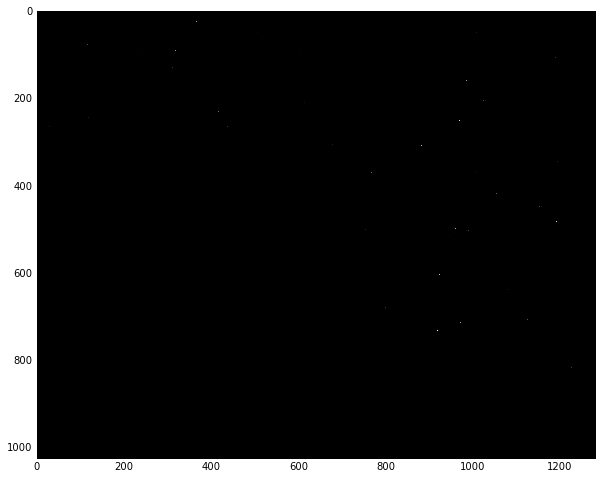

(<matplotlib.image.AxesImage at 0x2220e49e400>, None)

In [44]:
#find local maxima
localMax = peak_local_max(dist, indices=False, min_distance=20, labels=t1)

plt.imshow(localMax, cmap = 'gray'), plt.show()

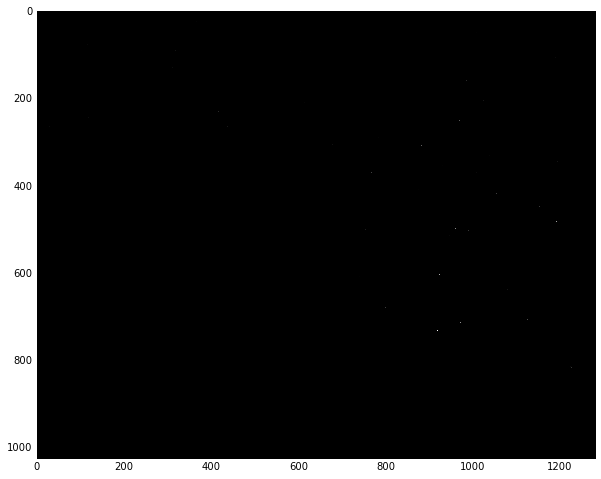

(<matplotlib.image.AxesImage at 0x2220e4ff8d0>, None)

In [45]:
markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
plt.imshow(markers, cmap = 'gray'), plt.show()

[INFO] 61 unique segments found


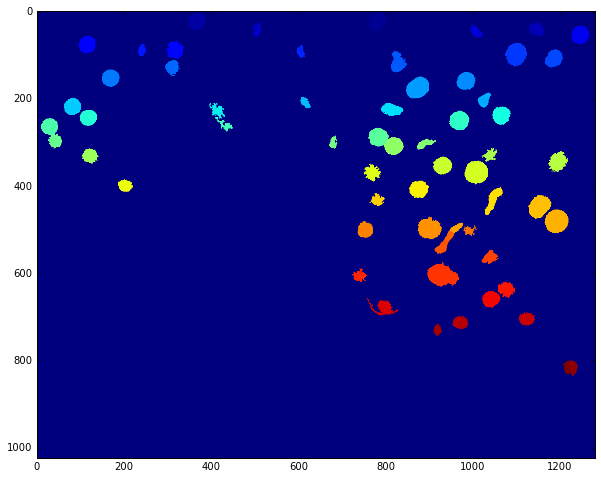

(<matplotlib.image.AxesImage at 0x2220e563c50>, None)

In [46]:
#perform watershed
labels = watershed(-dist, markers, mask=t1)
#labels = cv2.watershed(img, markers)
print("[INFO] {} unique segments found".format(len(np.unique(labels)) - 1))
plt.imshow(labels), plt.show()

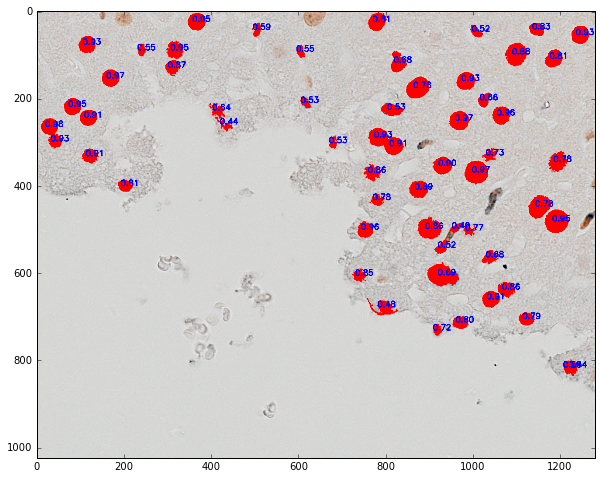

(<matplotlib.image.AxesImage at 0x22206a35278>, None)

In [47]:
for label in np.unique(labels):
    # if the label is zero, we are examining the 'background'
    # so simply ignore it
    if label == 0:
        continue
 
    # otherwise, allocate memory for the label region and draw
    # it on the mask
    mask = np.zeros(dist.shape, dtype="uint8")
    mask[labels == label] = 255
 
    # detect contours in the mask and grab the largest one
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[-2]
    for c in cnts:
        if cv2.contourArea(c) >= 300: #750:
            (x,y),(MA,ma),angle = cv2.fitEllipse(c)
            #x,y,w,h = cv2.boundingRect(c)
            #if MA/ma <= 0.4 and cv2.contourArea(c) < 1000 or MA/ma <= 0.35:
            #   cv2.drawContours(image, [c],0,(0,255,0),-1)
            #else:
            if (MA/ma) >= 0.4:
                cv2.drawContours(image, [c],0,255, -1)
                cv2.putText(image, "{0:.2f}".format(MA/ma), (int(x) - 10, int(y)),cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

# show the output image
plt.imshow(image), plt.show()

In [48]:
#----------------PASS 2-------------------------

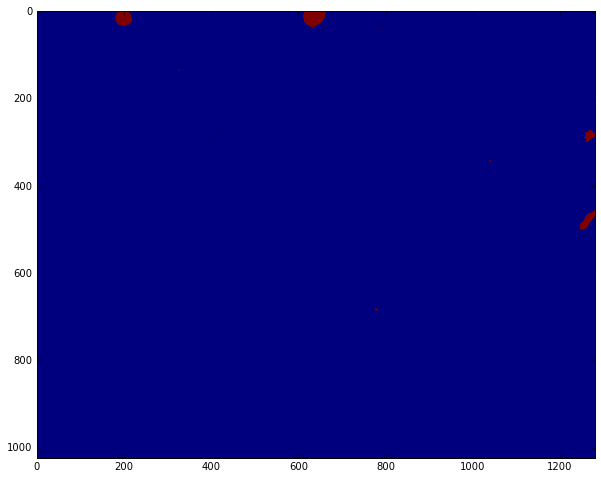

(<matplotlib.image.AxesImage at 0x2220724dd68>, None)

In [49]:
t2 = np.zeros(t1.shape, np.uint8)

a = t1[:] != 0
b = labels[:] != 0

t2[a] = 255
t2[b] = 0

plt.imshow(t2), plt.show()

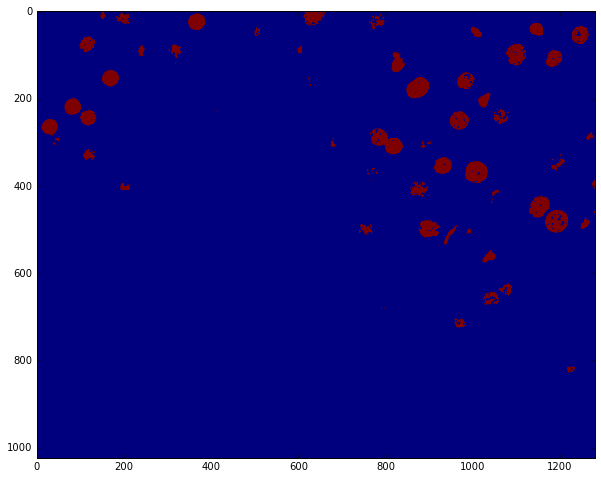

(<matplotlib.image.AxesImage at 0x22208445b00>, None)

In [50]:
b,g,r = cv2.split(img)
rgb_img = cv2.merge([r,g,b])
rg = cv2.merge([r,g,b])
rg = rg.astype(np.float32)

np.seterr(all = 'ignore')
mask = np.empty_like(rg)
arr_max = rg.max(-1)
delta = rg.ptp(-1)
s = delta/arr_max
s[delta==0]=0
idx = (rg[:,:,0] == arr_max)
mask[idx,0] = np.true_divide((rg[idx,1] - rg[idx,2]), delta[idx])
idx = (rg[:,:,1] == arr_max)
mask[idx,0] = 2. + np.true_divide((rg[idx,2] - rg[idx,0]), delta[idx])
idx = (rg[:,:,2] == arr_max)
mask[idx,0] = 4. + np.true_divide((rg[idx,0]-rg[idx,1]), delta[idx])
mask[:,:,0] = ((mask[:,:,0]/6.0)%1.0)*255.0
mask[:,:,0] = np.nan_to_num(mask[:,:,0])
mask[:,:,1] = s * 255.0
mask[:,:,2] = arr_max
mask = mask.astype(np.uint8)

nuclei_points = cv2.inRange(mask, (140, 70, 120), (180, 255, 210))
plt.imshow(nuclei_points), plt.show()

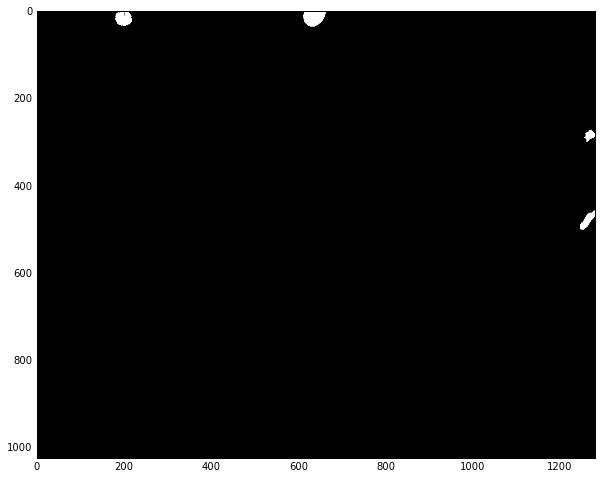

(<matplotlib.image.AxesImage at 0x222084af630>, None)

In [51]:
im2, nuclei_contours, h = cv2.findContours(nuclei_points, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
im2, cnts,h = cv2.findContours(t2, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
t3 = np.zeros(t2.shape, np.uint8)

for z in range(len(cnts)):
    for i in range(len(nuclei_contours)):
        for j in range(len(nuclei_contours[i])):
            x = nuclei_contours[i][j][0][0]
            y = nuclei_contours[i][j][0][1]
            points = (x,y)
            num = cv2.pointPolygonTest(cnts[z],points, False)
            if num == 0 or num == 1:
                cv2.drawContours(t3, [cnts[z]], 0, 255, -1)
            
plt.imshow(t3, cmap = 'gray'), plt.show()

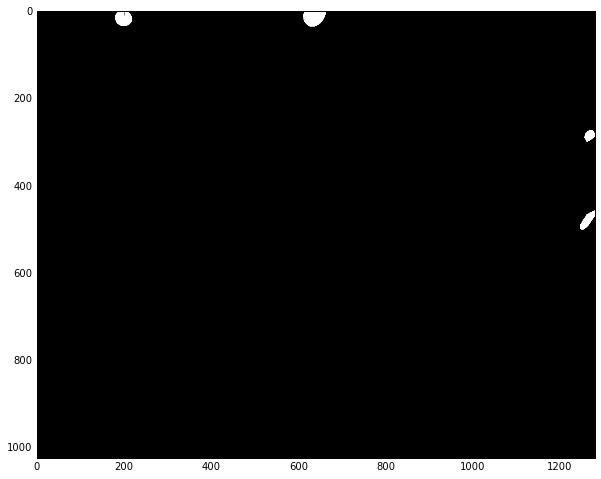

(<matplotlib.image.AxesImage at 0x2220b114400>, None)

In [52]:
im2, cnts, h = cv2.findContours(t3, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

hull = []
for c in cnts:
    if cv2.contourArea(c) > 300: #> 600:
        hull.append(cv2.convexHull(c))
        
t4 = np.zeros(t3.shape, np.uint8)

for h in hull:
    cv2.fillConvexPoly(t4, h, 255)
    
plt.imshow(t4, cmap = 'gray'), plt.show()

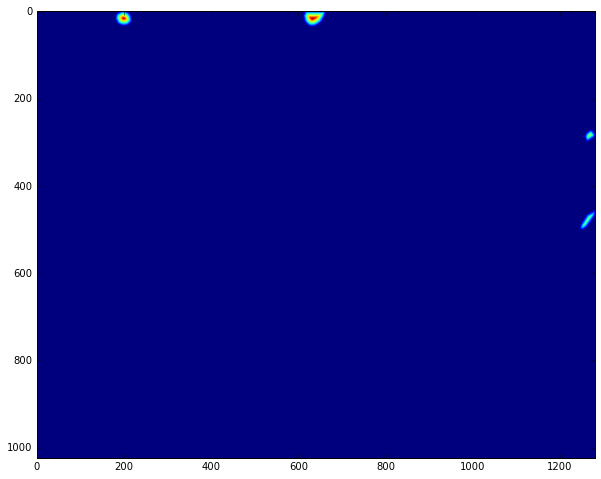

(<matplotlib.image.AxesImage at 0x2220b16e6a0>, None)

In [53]:
#distance transfrom on threshold image
dist = cv2.distanceTransform(t4, cv2.DIST_L2, 5)

plt.imshow(dist), plt.show()

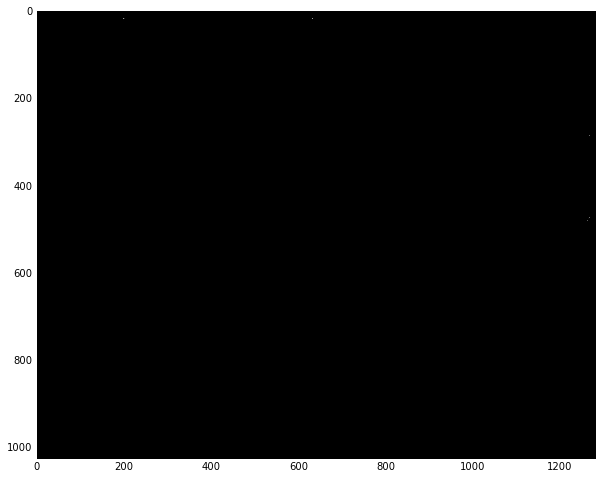

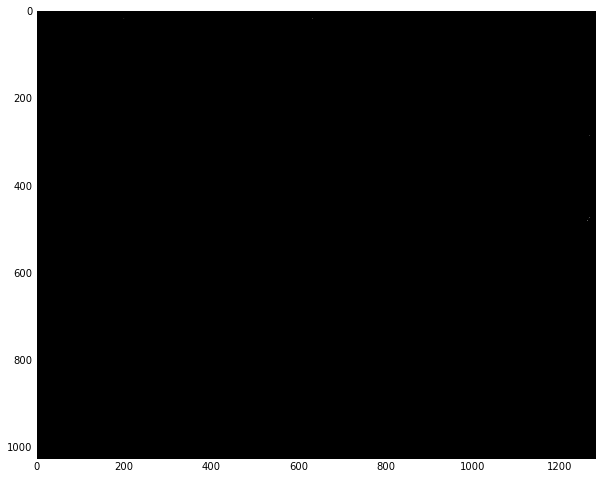

[INFO] 6 unique segments found


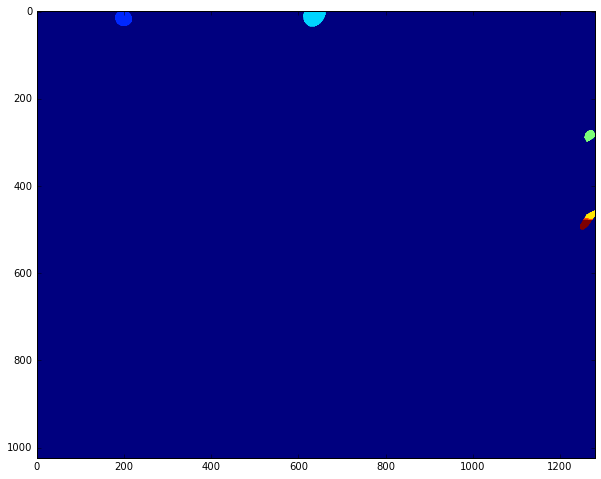

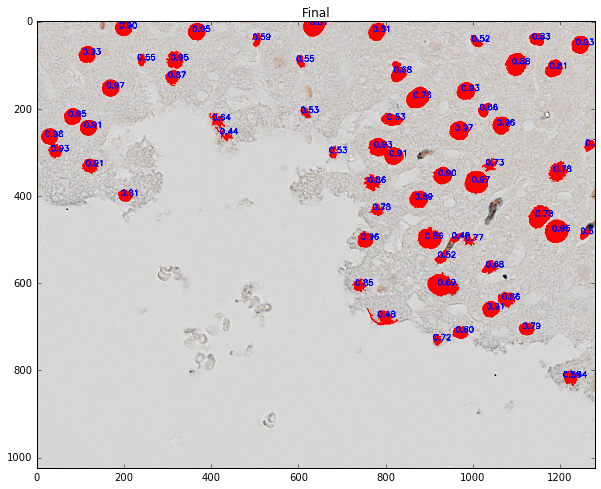

(<matplotlib.image.AxesImage at 0x2220ae490f0>,
 None)

In [54]:
#find local maxima
localMax = peak_local_max(dist, indices=False, min_distance=10, labels=t4)

plt.imshow(localMax, cmap = 'gray'), plt.show()
markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
plt.imshow(markers, cmap = 'gray'), plt.show()
#perform watershed
labels = watershed(-dist, markers, mask=t4)
print("[INFO] {} unique segments found".format(len(np.unique(labels)) - 1))
plt.imshow(labels), plt.show()
for label in np.unique(labels):
    # if the label is zero, we are examining the 'background'
    # so simply ignore it
    if label == 0:
        continue
 
    # otherwise, allocate memory for the label region and draw
    # it on the mask
    mask = np.zeros(dist.shape, dtype="uint8")
    mask[labels == label] = 255
 
    # detect contours in the mask and grab the largest one
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[-2]
    for c in cnts: 
        (x,y),(MA,ma),angle = cv2.fitEllipse(c)
        
        if cv2.contourArea(c) > 300 and (MA/ma) >= 0.5:
            cv2.drawContours(image, [c],0,255, -1)
            cv2.putText(image, "{0:.2f}".format(MA/ma), (int(x) - 10, int(y)),cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
        
# show the output image
plt.imshow(image), plt.title("Final"), plt.show()